In [1]:
import sys
sys.path.append('..')
from jaewook_header import *
%matplotlib inline

Using TensorFlow backend.


In [2]:
images=np.load('../../input/data1-L-images-conn.npy')
masks=np.load('../../input/data1-L-masks-conn.npy')

model_name='1202-dilated-unet.h5'
model_name2='1202-dilated-unet-more.h5'

IMG_HEIGHT,IMG_WIDTH=images.shape[1:3]
BATCH_SIZE=32

In [3]:
from sklearn.model_selection import train_test_split
images_train, images_val, masks_train, masks_val =\
train_test_split(images,masks,test_size=.1,random_state=seed)

# Augmentation

In [4]:
data_gen_args=dict(rotation_range=45,
                   width_shift_range=.2,
                   height_shift_range=.2,
                   shear_range=.7,
                   zoom_range=[.9,2.2],
                   horizontal_flip=True,
                   fill_mode='constant')

# train

images_train_datagen=ImageDataGenerator(**data_gen_args)
masks_train_datagen=ImageDataGenerator(**data_gen_args)

images_train_generator=images_train_datagen.flow(images_train,
                                                 batch_size=BATCH_SIZE,
                                                 seed=seed)
masks_train_generator=masks_train_datagen.flow(masks_train,
                                               batch_size=BATCH_SIZE,
                                               seed=seed)

train_generator=zip(images_train_generator,masks_train_generator)

# validation

images_val_datagen=ImageDataGenerator()
masks_val_datagen=ImageDataGenerator()

images_val_generator=images_val_datagen.flow(images_val,seed=seed)
masks_val_generator=masks_val_datagen.flow(masks_val,seed=seed)

val_generator=zip(images_val_generator,masks_val_generator)

C:\Users\snu\AppData\Local\Continuum\anaconda3\envs\venv\lib\site-packages\keras_preprocessing\image.py:1643: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (60, 256, 256, 8) (8 channels).
  str(self.x.shape[channels_axis]) + ' channels).')
C:\Users\snu\AppData\Local\Continuum\anaconda3\envs\venv\lib\site-packages\keras_preprocessing\image.py:1643: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (7, 256, 256, 8) (8 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


# Sanity Check

C:\Users\snu\AppData\Local\Continuum\anaconda3\envs\venv\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


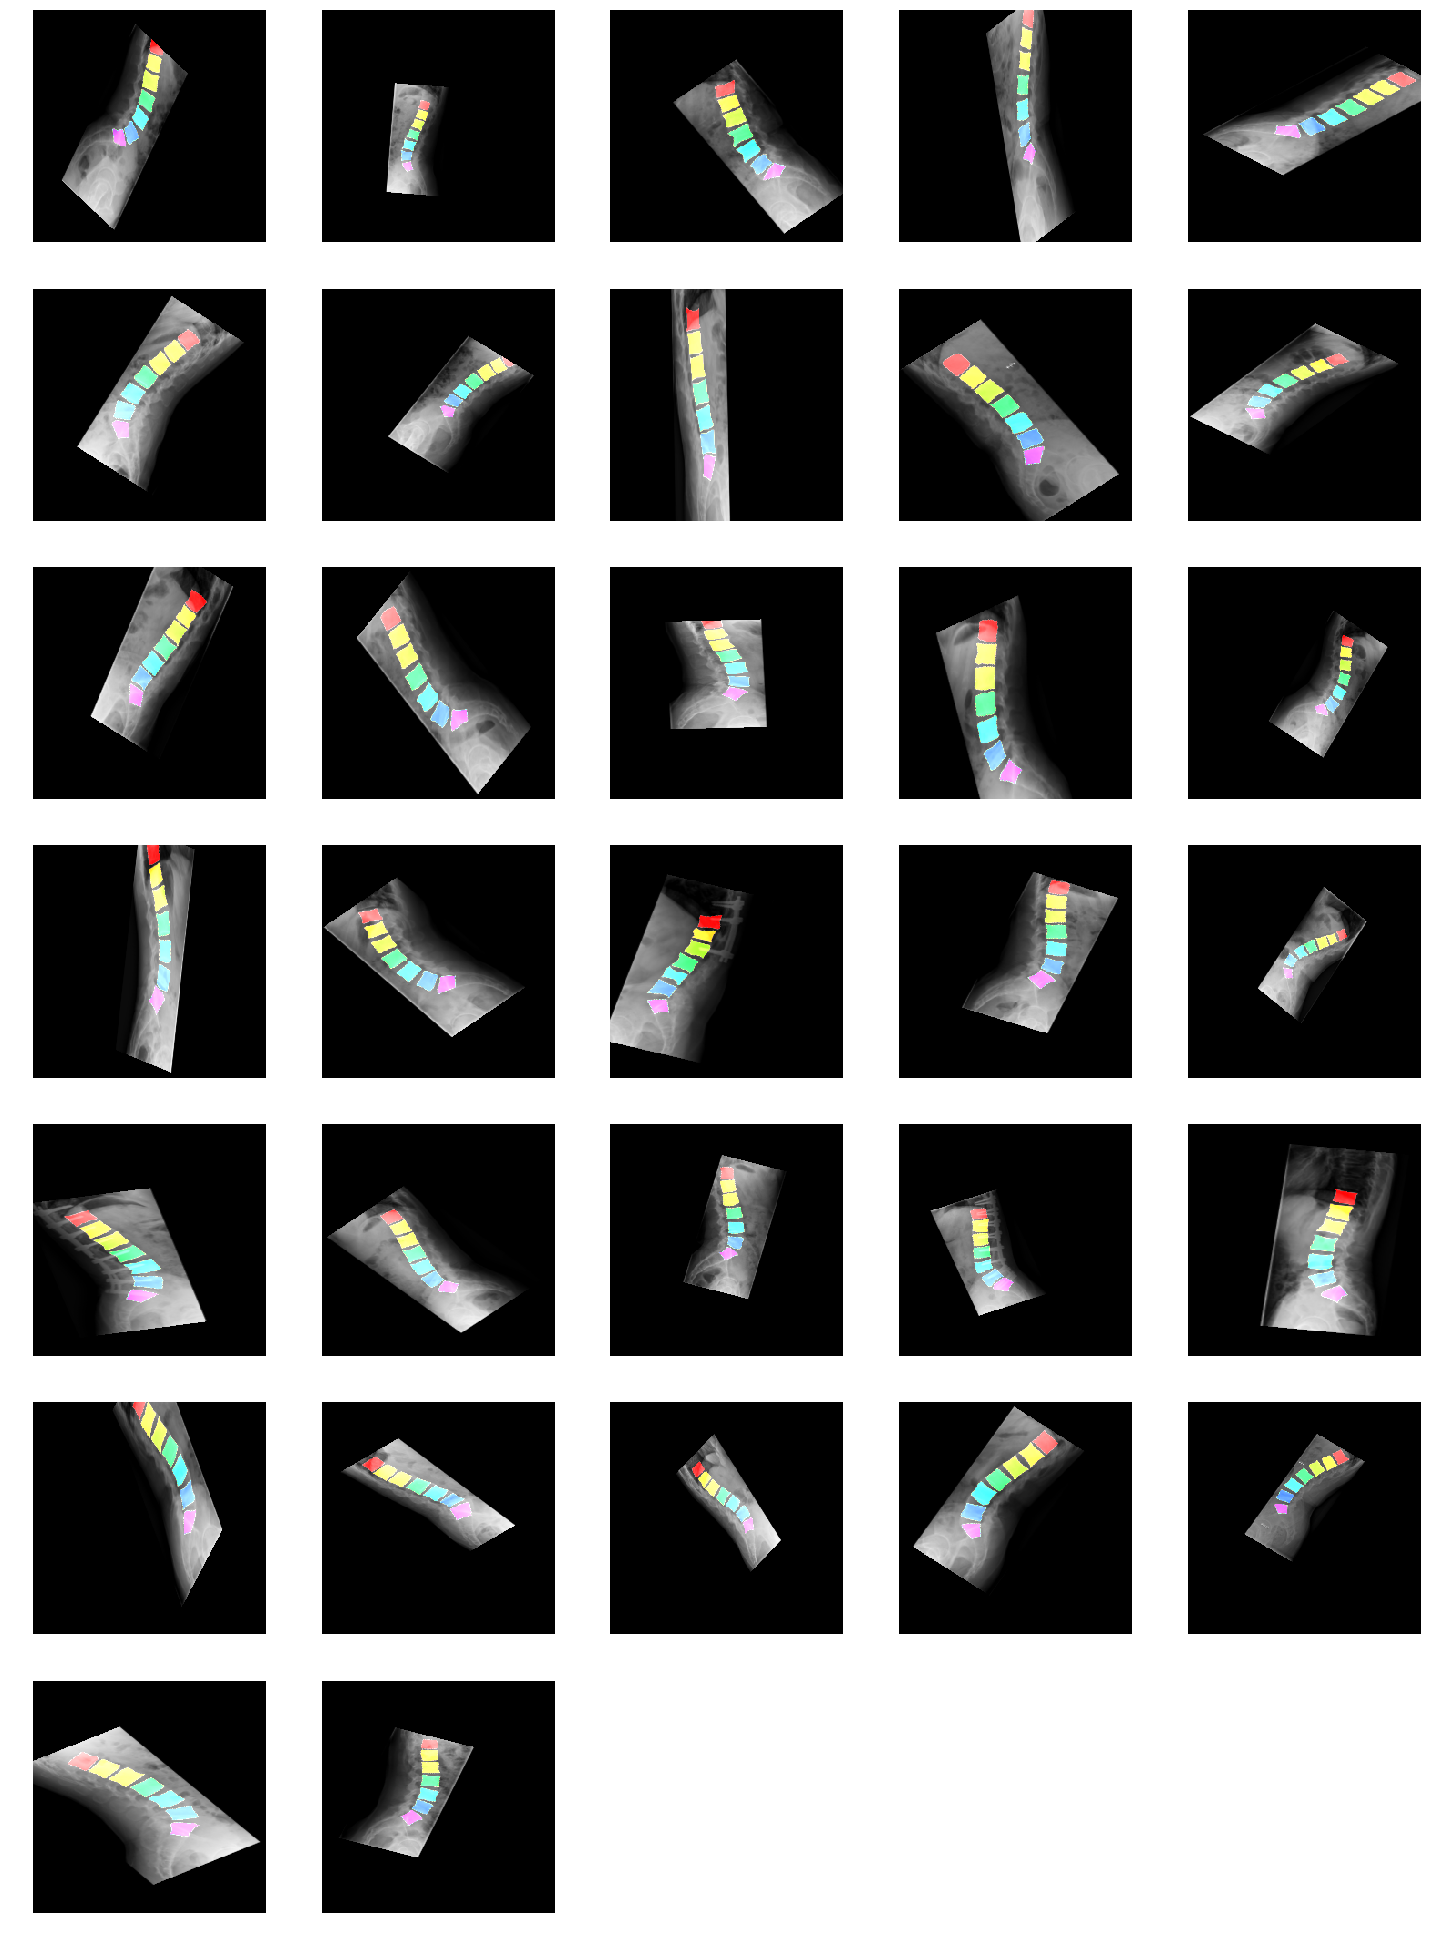

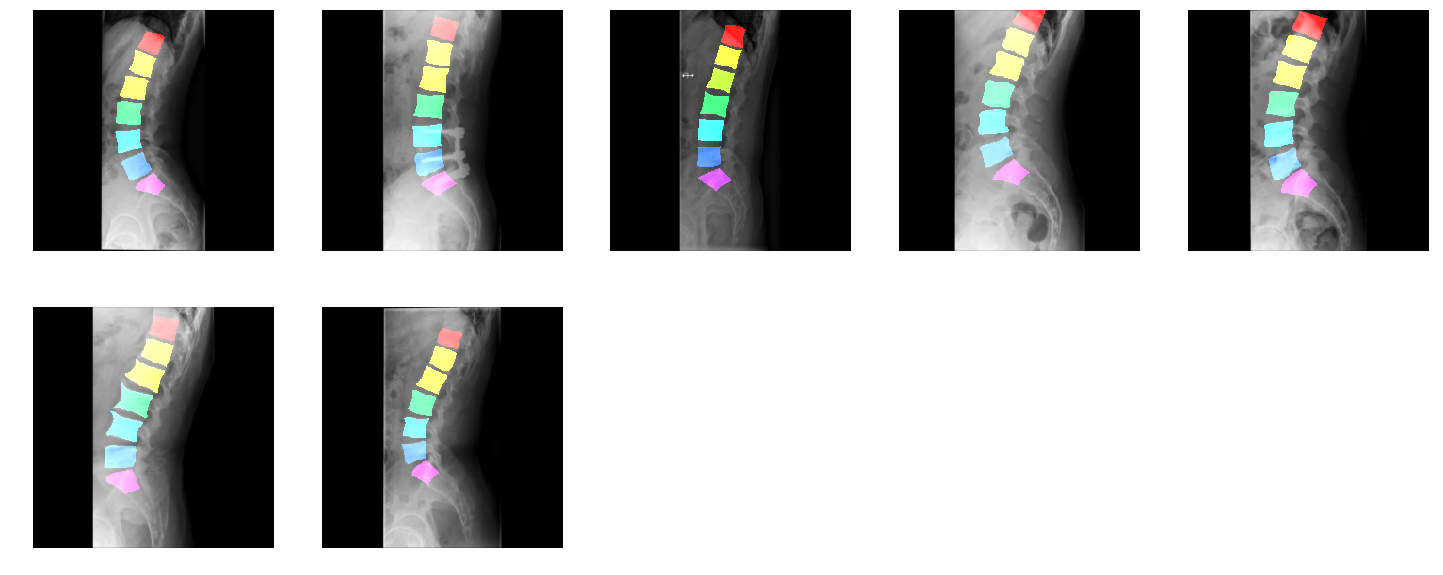

In [5]:
# train
images_preview, masks_preview = next(train_generator)
imshow2(overlay(images_preview,level(masks_preview)))
# val
images_preview, masks_preview = next(val_generator)
imshow2(overlay(images_preview,level(masks_preview)))

In [6]:
# 남의 코드
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

# Model

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 256, 256, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 256, 256, 8)  24333000    lambda_1[0][0]                   
                                                                 lambda_2[0][0]                   
__________

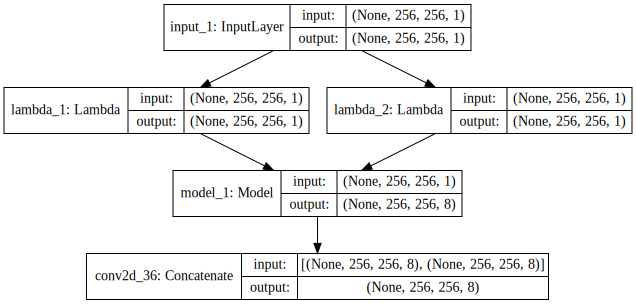

In [7]:
# 제욱 U-net
inputs = Input((IMG_HEIGHT, IMG_WIDTH, 1))


def down_unit(inputs,channel):
    c1 = Conv2D(channel, 
                (3, 3),
                activation='elu',
                kernel_initializer='he_normal',
                padding='same')(inputs)
    b1 = BatchNormalization()(c1)
    c2 = Conv2D(channel, 
                (3, 3),
                activation='elu',
                kernel_initializer='he_normal',
                padding='same')(b1)
    b2 = BatchNormalization()(c2)
    c3 = Conv2D(channel, 
                (3, 3),
                activation='elu',
                kernel_initializer='he_normal',
                padding='same')(b2)
    m = MaxPooling2D((2, 2))(c3)
    return c3, m


def up_unit(inputs, skip, channel):
    ct = Conv2DTranspose(channel, 
                          (2, 2), 
                          strides=(2, 2), 
                          padding='same') (inputs)
    co = concatenate([skip, ct])
    c1 = Conv2D(channel, 
                (3, 3),
                activation='elu',
                kernel_initializer='he_normal',
                padding='same')(co)
    b1 = BatchNormalization()(c1)
    c2 = Conv2D(channel, 
                (3, 3),
                activation='elu',
                kernel_initializer='he_normal',
                padding='same')(b1)
    b2 = BatchNormalization()(c2)
    c3 = Conv2D(channel, 
                (3, 3),
                activation='elu',
                kernel_initializer='he_normal',
                padding='same')(b2)
    return c3


def dilatedConv(inputs):
    c = Conv2D(512,
               (3, 3),
               dilation_rate=(2, 2),
               activation='elu',
               kernel_initializer='he_normal',
               padding='same')(inputs)
    return BatchNormalization()(c)


skip=[None]*5

skip[0], down = down_unit(inputs,32)
skip[1], down = down_unit(down,64)
skip[2], down = down_unit(down,128)
skip[3], down = down_unit(down,256)
skip[4], middle = down_unit(down,512)

middle = dilatedConv(middle)
middle = dilatedConv(middle)
middle = dilatedConv(middle)
middle = dilatedConv(middle)
middle = dilatedConv(middle)

up = up_unit(middle, skip[4], 256)
up = up_unit(up, skip[3], 128)
up = up_unit(up, skip[2], 64)
up = up_unit(up, skip[1], 32)
up = up_unit(up, skip[0], 32)
outputs = Conv2D(8, (1, 1), activation='sigmoid') (up)

model=Model(inputs=[inputs],outputs=[outputs])
model=multi_gpu_model(model,gpus=2)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

Epoch 1/10
100/100 [==============================] - 111s 1s/step - loss: 0.1134 - mean_iou: 0.4791 - val_loss: 0.0548 - val_mean_iou: 0.4953

Epoch 00001: val_mean_iou improved from -inf to 0.49534, saving model to 1202-dilated-unet.h5
Epoch 2/10
100/100 [==============================] - 97s 974ms/step - loss: 0.0203 - mean_iou: 0.4970 - val_loss: 0.0809 - val_mean_iou: 0.4991

Epoch 00002: val_mean_iou improved from 0.49534 to 0.49914, saving model to 1202-dilated-unet.h5
Epoch 3/10
100/100 [==============================] - 97s 972ms/step - loss: 0.0166 - mean_iou: 0.5043 - val_loss: 0.0899 - val_mean_iou: 0.5111

Epoch 00003: val_mean_iou improved from 0.49914 to 0.51110, saving model to 1202-dilated-unet.h5
Epoch 4/10
100/100 [==============================] - 98s 978ms/step - loss: 0.0146 - mean_iou: 0.5190 - val_loss: 0.0461 - val_mean_iou: 0.5275

Epoch 00004: val_mean_iou improved from 0.51110 to 0.52750, saving model to 1202-dilated-unet.h5
Epoch 5/10
100/100 [=============

C:\Users\snu\AppData\Local\Continuum\anaconda3\envs\venv\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


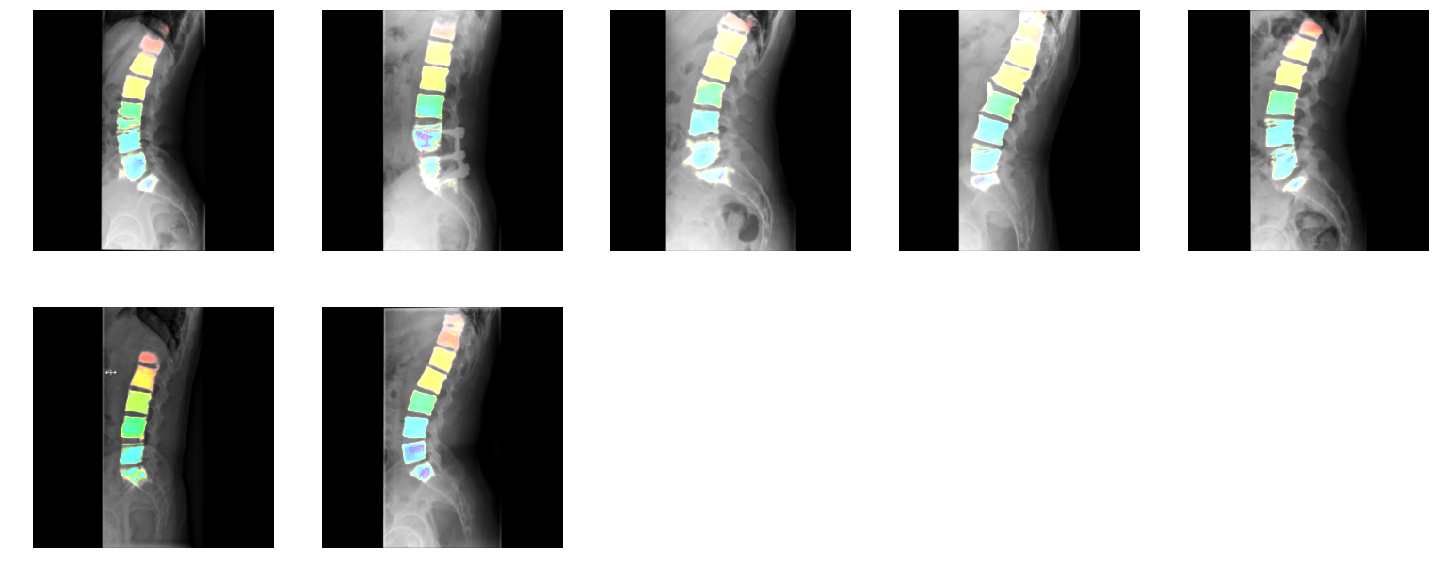

In [8]:
checkpointer = ModelCheckpoint(model_name,
                               monitor='val_mean_iou',
                               mode='max',
                               verbose=1,
                               save_best_only=True)

results=model.fit_generator(train_generator,
                            validation_data=val_generator,
                            validation_steps=1,
                            steps_per_epoch=100,
                            epochs=10,
                            callbacks=[checkpointer])

imshow2(overlay(images_val,level(model.predict(images_val))))

Epoch 1/100
100/100 [==============================] - 98s 983ms/step - loss: 0.0054 - mean_iou: 0.6370 - val_loss: 0.0288 - val_mean_iou: 0.6457

Epoch 00001: val_mean_iou improved from 0.62920 to 0.64573, saving model to 1202-dilated-unet.h5
Epoch 2/100
100/100 [==============================] - 97s 971ms/step - loss: 0.0040 - mean_iou: 0.6538 - val_loss: 0.0203 - val_mean_iou: 0.6618

Epoch 00002: val_mean_iou improved from 0.64573 to 0.66180, saving model to 1202-dilated-unet.h5
Epoch 3/100
100/100 [==============================] - 97s 972ms/step - loss: 0.0040 - mean_iou: 0.6691 - val_loss: 0.0207 - val_mean_iou: 0.6760

Epoch 00003: val_mean_iou improved from 0.66180 to 0.67603, saving model to 1202-dilated-unet.h5
Epoch 4/100
100/100 [==============================] - 97s 972ms/step - loss: 0.0032 - mean_iou: 0.6829 - val_loss: 0.0116 - val_mean_iou: 0.6896

Epoch 00004: val_mean_iou improved from 0.67603 to 0.68961, saving model to 1202-dilated-unet.h5
Epoch 5/100
100/100 [===


Epoch 00034: val_mean_iou improved from 0.83769 to 0.83966, saving model to 1202-dilated-unet.h5
Epoch 35/100
100/100 [==============================] - 97s 973ms/step - loss: 0.0019 - mean_iou: 0.8406 - val_loss: 0.0087 - val_mean_iou: 0.8416

Epoch 00035: val_mean_iou improved from 0.83966 to 0.84164, saving model to 1202-dilated-unet.h5
Epoch 36/100
100/100 [==============================] - 97s 974ms/step - loss: 0.0018 - mean_iou: 0.8426 - val_loss: 0.0060 - val_mean_iou: 0.8436

Epoch 00036: val_mean_iou improved from 0.84164 to 0.84362, saving model to 1202-dilated-unet.h5
Epoch 37/100
100/100 [==============================] - 97s 973ms/step - loss: 0.0018 - mean_iou: 0.8446 - val_loss: 0.0076 - val_mean_iou: 0.8456

Epoch 00037: val_mean_iou improved from 0.84362 to 0.84556, saving model to 1202-dilated-unet.h5
Epoch 38/100
100/100 [==============================] - 97s 972ms/step - loss: 0.0018 - mean_iou: 0.8465 - val_loss: 0.0107 - val_mean_iou: 0.8474

Epoch 00038: val_me

100/100 [==============================] - 97s 970ms/step - loss: 0.0015 - mean_iou: 0.8818 - val_loss: 0.0072 - val_mean_iou: 0.8823

Epoch 00068: val_mean_iou improved from 0.88143 to 0.88227, saving model to 1202-dilated-unet.h5
Epoch 69/100
100/100 [==============================] - 97s 971ms/step - loss: 0.0014 - mean_iou: 0.8827 - val_loss: 0.0070 - val_mean_iou: 0.8831

Epoch 00069: val_mean_iou improved from 0.88227 to 0.88308, saving model to 1202-dilated-unet.h5
Epoch 70/100
100/100 [==============================] - 97s 975ms/step - loss: 0.0026 - mean_iou: 0.8833 - val_loss: 0.0230 - val_mean_iou: 0.8835

Epoch 00070: val_mean_iou improved from 0.88308 to 0.88348, saving model to 1202-dilated-unet.h5
Epoch 71/100
100/100 [==============================] - 97s 969ms/step - loss: 0.0021 - mean_iou: 0.8837 - val_loss: 0.0132 - val_mean_iou: 0.8840

Epoch 00071: val_mean_iou improved from 0.88348 to 0.88401, saving model to 1202-dilated-unet.h5
Epoch 72/100
100/100 [===========

C:\Users\snu\AppData\Local\Continuum\anaconda3\envs\venv\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


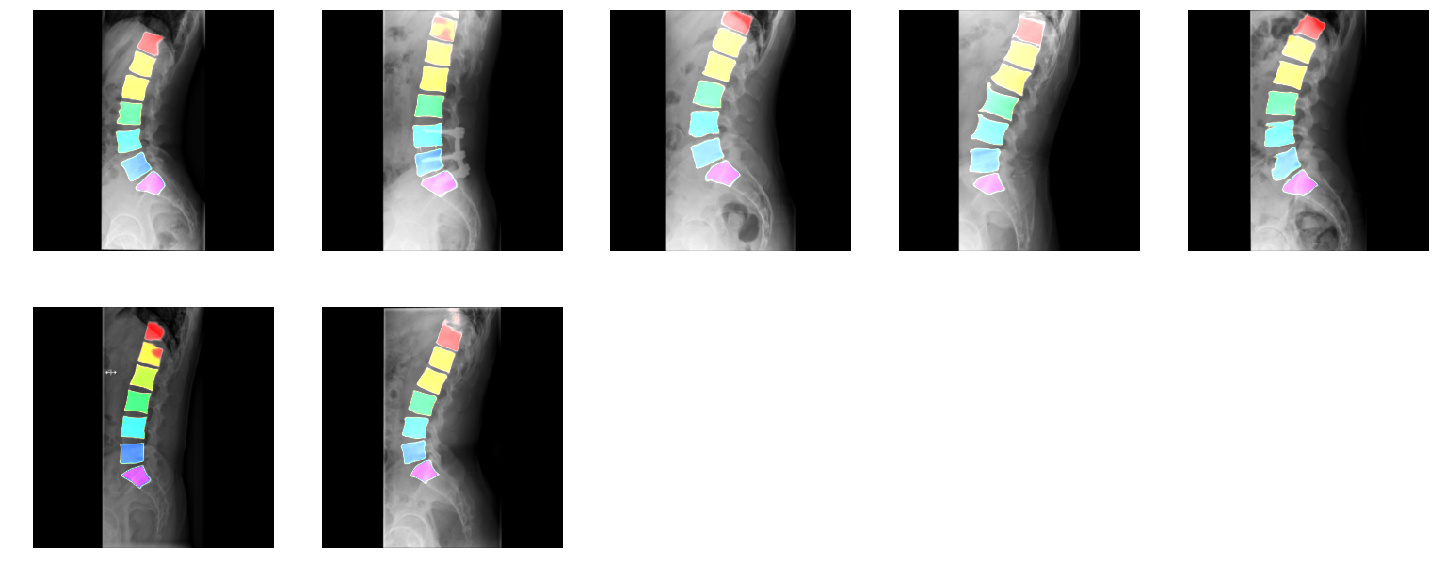

In [9]:
results=model.fit_generator(train_generator,
                            validation_data=val_generator,
                            validation_steps=1,
                            steps_per_epoch=100,
                            epochs=100,
                            callbacks=[checkpointer])

model=load_model(model_name,custom_objects={'mean_iou':mean_iou})
imshow2(overlay(images_val,level(model.predict(images_val))))

In [13]:
model=load_model(model_name,custom_objects={'mean_iou':mean_iou})
model=multi_gpu_model(model.layers[-2],gpus=2)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 256, 256, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 256, 256, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 256, 256, 8)  24333000    lambda_5[0][0]                   
                                                                 lambda_6[0][0]                   
__________

Epoch 1/500
100/100 [==============================] - 113s 1s/step - loss: 0.0027 - mean_iou: 0.8990 - val_loss: 0.0078 - val_mean_iou: 0.9388

Epoch 00001: val_mean_iou improved from -inf to 0.93879, saving model to 1202-dilated-unet-more.h5
Epoch 2/500
100/100 [==============================] - 97s 969ms/step - loss: 0.0014 - mean_iou: 0.9424 - val_loss: 0.0072 - val_mean_iou: 0.9450

Epoch 00002: val_mean_iou improved from 0.93879 to 0.94496, saving model to 1202-dilated-unet-more.h5
Epoch 3/500
100/100 [==============================] - 97s 971ms/step - loss: 0.0014 - mean_iou: 0.9461 - val_loss: 0.0081 - val_mean_iou: 0.9469

Epoch 00003: val_mean_iou improved from 0.94496 to 0.94688, saving model to 1202-dilated-unet-more.h5
Epoch 4/500
100/100 [==============================] - 97s 972ms/step - loss: 0.0014 - mean_iou: 0.9474 - val_loss: 0.0062 - val_mean_iou: 0.9480

Epoch 00004: val_mean_iou improved from 0.94688 to 0.94797, saving model to 1202-dilated-unet-more.h5
Epoch 5/5


Epoch 00036: val_mean_iou did not improve from 0.95211
Epoch 37/500
100/100 [==============================] - 97s 975ms/step - loss: 0.0018 - mean_iou: 0.9509 - val_loss: 0.0095 - val_mean_iou: 0.9507

Epoch 00037: val_mean_iou did not improve from 0.95211
Epoch 38/500
100/100 [==============================] - 98s 975ms/step - loss: 0.0015 - mean_iou: 0.9506 - val_loss: 0.0088 - val_mean_iou: 0.9506

Epoch 00038: val_mean_iou did not improve from 0.95211
Epoch 39/500
100/100 [==============================] - 98s 977ms/step - loss: 0.0014 - mean_iou: 0.9506 - val_loss: 0.0070 - val_mean_iou: 0.9506

Epoch 00039: val_mean_iou did not improve from 0.95211
Epoch 40/500
100/100 [==============================] - 97s 974ms/step - loss: 0.0015 - mean_iou: 0.9505 - val_loss: 0.0070 - val_mean_iou: 0.9505

Epoch 00040: val_mean_iou did not improve from 0.95211
Epoch 41/500
100/100 [==============================] - 98s 977ms/step - loss: 0.0013 - mean_iou: 0.9505 - val_loss: 0.0082 - val_me

100/100 [==============================] - 98s 979ms/step - loss: 0.0011 - mean_iou: 0.9530 - val_loss: 0.0077 - val_mean_iou: 0.9530

Epoch 00074: val_mean_iou improved from 0.95297 to 0.95303, saving model to 1202-dilated-unet-more.h5
Epoch 75/500
100/100 [==============================] - 98s 982ms/step - loss: 0.0012 - mean_iou: 0.9531 - val_loss: 0.0077 - val_mean_iou: 0.9531

Epoch 00075: val_mean_iou improved from 0.95303 to 0.95309, saving model to 1202-dilated-unet-more.h5
Epoch 76/500
100/100 [==============================] - 98s 979ms/step - loss: 0.0011 - mean_iou: 0.9531 - val_loss: 0.0072 - val_mean_iou: 0.9531

Epoch 00076: val_mean_iou improved from 0.95309 to 0.95315, saving model to 1202-dilated-unet-more.h5
Epoch 77/500
100/100 [==============================] - 98s 980ms/step - loss: 0.0011 - mean_iou: 0.9532 - val_loss: 0.0071 - val_mean_iou: 0.9532

Epoch 00077: val_mean_iou improved from 0.95315 to 0.95321, saving model to 1202-dilated-unet-more.h5
Epoch 78/500


Epoch 110/500
100/100 [==============================] - 98s 981ms/step - loss: 0.0011 - mean_iou: 0.9540 - val_loss: 0.0080 - val_mean_iou: 0.9540

Epoch 00110: val_mean_iou improved from 0.95395 to 0.95400, saving model to 1202-dilated-unet-more.h5
Epoch 111/500
100/100 [==============================] - 98s 981ms/step - loss: 0.0011 - mean_iou: 0.9540 - val_loss: 0.0081 - val_mean_iou: 0.9540

Epoch 00111: val_mean_iou improved from 0.95400 to 0.95404, saving model to 1202-dilated-unet-more.h5
Epoch 112/500
100/100 [==============================] - 98s 981ms/step - loss: 0.0011 - mean_iou: 0.9541 - val_loss: 0.0089 - val_mean_iou: 0.9541

Epoch 00112: val_mean_iou improved from 0.95404 to 0.95408, saving model to 1202-dilated-unet-more.h5
Epoch 113/500
100/100 [==============================] - 98s 983ms/step - loss: 0.0011 - mean_iou: 0.9541 - val_loss: 0.0078 - val_mean_iou: 0.9541

Epoch 00113: val_mean_iou improved from 0.95408 to 0.95412, saving model to 1202-dilated-unet-more


Epoch 00145: val_mean_iou did not improve from 0.95473
Epoch 146/500
100/100 [==============================] - 98s 979ms/step - loss: 0.0011 - mean_iou: 0.9546 - val_loss: 0.0089 - val_mean_iou: 0.9547

Epoch 00146: val_mean_iou did not improve from 0.95473
Epoch 147/500
100/100 [==============================] - 98s 978ms/step - loss: 0.0011 - mean_iou: 0.9547 - val_loss: 0.0068 - val_mean_iou: 0.9547

Epoch 00147: val_mean_iou did not improve from 0.95473
Epoch 148/500
100/100 [==============================] - 98s 978ms/step - loss: 0.0011 - mean_iou: 0.9547 - val_loss: 0.0071 - val_mean_iou: 0.9547

Epoch 00148: val_mean_iou did not improve from 0.95473
Epoch 149/500
100/100 [==============================] - 98s 978ms/step - loss: 0.0011 - mean_iou: 0.9547 - val_loss: 0.0075 - val_mean_iou: 0.9548

Epoch 00149: val_mean_iou improved from 0.95473 to 0.95475, saving model to 1202-dilated-unet-more.h5
Epoch 150/500
100/100 [==============================] - 98s 983ms/step - loss: 0

100/100 [==============================] - 98s 981ms/step - loss: 0.0014 - mean_iou: 0.9554 - val_loss: 0.0118 - val_mean_iou: 0.9554

Epoch 00180: val_mean_iou did not improve from 0.95545
Epoch 181/500
100/100 [==============================] - 98s 981ms/step - loss: 0.0015 - mean_iou: 0.9554 - val_loss: 0.0103 - val_mean_iou: 0.9554

Epoch 00181: val_mean_iou did not improve from 0.95545
Epoch 182/500
100/100 [==============================] - 98s 982ms/step - loss: 0.0015 - mean_iou: 0.9553 - val_loss: 0.0099 - val_mean_iou: 0.9553

Epoch 00182: val_mean_iou did not improve from 0.95545
Epoch 183/500
100/100 [==============================] - 98s 980ms/step - loss: 0.0013 - mean_iou: 0.9553 - val_loss: 0.0068 - val_mean_iou: 0.9553

Epoch 00183: val_mean_iou did not improve from 0.95545
Epoch 184/500
100/100 [==============================] - 98s 984ms/step - loss: 0.0012 - mean_iou: 0.9553 - val_loss: 0.0072 - val_mean_iou: 0.9553

Epoch 00184: val_mean_iou did not improve from 0.

100/100 [==============================] - 99s 986ms/step - loss: 0.0010 - mean_iou: 0.9559 - val_loss: 0.0076 - val_mean_iou: 0.9560

Epoch 00215: val_mean_iou improved from 0.95594 to 0.95596, saving model to 1202-dilated-unet-more.h5
Epoch 216/500
100/100 [==============================] - 98s 983ms/step - loss: 0.0010 - mean_iou: 0.9560 - val_loss: 0.0077 - val_mean_iou: 0.9560

Epoch 00216: val_mean_iou improved from 0.95596 to 0.95598, saving model to 1202-dilated-unet-more.h5
Epoch 217/500
100/100 [==============================] - 99s 987ms/step - loss: 0.0010 - mean_iou: 0.9560 - val_loss: 0.0072 - val_mean_iou: 0.9560

Epoch 00217: val_mean_iou improved from 0.95598 to 0.95600, saving model to 1202-dilated-unet-more.h5
Epoch 218/500
100/100 [==============================] - 98s 985ms/step - loss: 0.0010 - mean_iou: 0.9560 - val_loss: 0.0075 - val_mean_iou: 0.9560

Epoch 00218: val_mean_iou improved from 0.95600 to 0.95602, saving model to 1202-dilated-unet-more.h5
Epoch 219/

Epoch 248/500
100/100 [==============================] - 98s 982ms/step - loss: 0.0010 - mean_iou: 0.9566 - val_loss: 0.0080 - val_mean_iou: 0.9566

Epoch 00248: val_mean_iou improved from 0.95658 to 0.95660, saving model to 1202-dilated-unet-more.h5
Epoch 249/500
100/100 [==============================] - 99s 985ms/step - loss: 0.0010 - mean_iou: 0.9566 - val_loss: 0.0077 - val_mean_iou: 0.9566

Epoch 00249: val_mean_iou improved from 0.95660 to 0.95662, saving model to 1202-dilated-unet-more.h5
Epoch 250/500
100/100 [==============================] - 98s 984ms/step - loss: 0.0010 - mean_iou: 0.9566 - val_loss: 0.0076 - val_mean_iou: 0.9566

Epoch 00250: val_mean_iou improved from 0.95662 to 0.95664, saving model to 1202-dilated-unet-more.h5
Epoch 251/500
100/100 [==============================] - 98s 985ms/step - loss: 0.0011 - mean_iou: 0.9566 - val_loss: 0.0079 - val_mean_iou: 0.9567

Epoch 00251: val_mean_iou improved from 0.95664 to 0.95665, saving model to 1202-dilated-unet-more

Epoch 283/500
100/100 [==============================] - 99s 986ms/step - loss: 0.0010 - mean_iou: 0.9569 - val_loss: 0.0078 - val_mean_iou: 0.9570

Epoch 00283: val_mean_iou improved from 0.95694 to 0.95696, saving model to 1202-dilated-unet-more.h5
Epoch 284/500
100/100 [==============================] - 99s 985ms/step - loss: 0.0010 - mean_iou: 0.9570 - val_loss: 0.0076 - val_mean_iou: 0.9570

Epoch 00284: val_mean_iou improved from 0.95696 to 0.95697, saving model to 1202-dilated-unet-more.h5
Epoch 285/500
100/100 [==============================] - 98s 984ms/step - loss: 0.0010 - mean_iou: 0.9570 - val_loss: 0.0077 - val_mean_iou: 0.9570

Epoch 00285: val_mean_iou improved from 0.95697 to 0.95699, saving model to 1202-dilated-unet-more.h5
Epoch 286/500
100/100 [==============================] - 98s 984ms/step - loss: 0.0010 - mean_iou: 0.9570 - val_loss: 0.0077 - val_mean_iou: 0.9570

Epoch 00286: val_mean_iou improved from 0.95699 to 0.95700, saving model to 1202-dilated-unet-more


Epoch 00315: val_mean_iou improved from 0.95738 to 0.95739, saving model to 1202-dilated-unet-more.h5
Epoch 316/500
100/100 [==============================] - 98s 981ms/step - loss: 0.0010 - mean_iou: 0.9574 - val_loss: 0.0078 - val_mean_iou: 0.9574

Epoch 00316: val_mean_iou improved from 0.95739 to 0.95741, saving model to 1202-dilated-unet-more.h5
Epoch 317/500
100/100 [==============================] - 98s 979ms/step - loss: 0.0010 - mean_iou: 0.9574 - val_loss: 0.0085 - val_mean_iou: 0.9574

Epoch 00317: val_mean_iou improved from 0.95741 to 0.95742, saving model to 1202-dilated-unet-more.h5
Epoch 318/500
100/100 [==============================] - 98s 979ms/step - loss: 9.8420e-04 - mean_iou: 0.9574 - val_loss: 0.0081 - val_mean_iou: 0.9574

Epoch 00318: val_mean_iou improved from 0.95742 to 0.95743, saving model to 1202-dilated-unet-more.h5
Epoch 319/500
100/100 [==============================] - 98s 981ms/step - loss: 9.8767e-04 - mean_iou: 0.9574 - val_loss: 0.0079 - val_mean_

Epoch 348/500
100/100 [==============================] - 98s 978ms/step - loss: 9.8331e-04 - mean_iou: 0.9578 - val_loss: 0.0081 - val_mean_iou: 0.9578

Epoch 00348: val_mean_iou improved from 0.95779 to 0.95781, saving model to 1202-dilated-unet-more.h5
Epoch 349/500
100/100 [==============================] - 98s 979ms/step - loss: 9.9111e-04 - mean_iou: 0.9578 - val_loss: 0.0080 - val_mean_iou: 0.9578

Epoch 00349: val_mean_iou improved from 0.95781 to 0.95782, saving model to 1202-dilated-unet-more.h5
Epoch 350/500
100/100 [==============================] - 98s 978ms/step - loss: 9.8430e-04 - mean_iou: 0.9578 - val_loss: 0.0089 - val_mean_iou: 0.9578

Epoch 00350: val_mean_iou improved from 0.95782 to 0.95783, saving model to 1202-dilated-unet-more.h5
Epoch 351/500
100/100 [==============================] - 98s 976ms/step - loss: 9.7267e-04 - mean_iou: 0.9578 - val_loss: 0.0076 - val_mean_iou: 0.9578

Epoch 00351: val_mean_iou improved from 0.95783 to 0.95784, saving model to 1202-d

100/100 [==============================] - 98s 980ms/step - loss: 9.7115e-04 - mean_iou: 0.9582 - val_loss: 0.0090 - val_mean_iou: 0.9582

Epoch 00380: val_mean_iou improved from 0.95816 to 0.95817, saving model to 1202-dilated-unet-more.h5
Epoch 381/500
100/100 [==============================] - 98s 981ms/step - loss: 9.6085e-04 - mean_iou: 0.9582 - val_loss: 0.0088 - val_mean_iou: 0.9582

Epoch 00381: val_mean_iou improved from 0.95817 to 0.95818, saving model to 1202-dilated-unet-more.h5
Epoch 382/500
100/100 [==============================] - 98s 978ms/step - loss: 9.6731e-04 - mean_iou: 0.9582 - val_loss: 0.0085 - val_mean_iou: 0.9582

Epoch 00382: val_mean_iou improved from 0.95818 to 0.95819, saving model to 1202-dilated-unet-more.h5
Epoch 383/500
100/100 [==============================] - 98s 977ms/step - loss: 9.6545e-04 - mean_iou: 0.9582 - val_loss: 0.0084 - val_mean_iou: 0.9582

Epoch 00383: val_mean_iou improved from 0.95819 to 0.95820, saving model to 1202-dilated-unet-mo

100/100 [==============================] - 98s 985ms/step - loss: 9.6237e-04 - mean_iou: 0.9584 - val_loss: 0.0082 - val_mean_iou: 0.9584

Epoch 00414: val_mean_iou improved from 0.95839 to 0.95840, saving model to 1202-dilated-unet-more.h5
Epoch 415/500
100/100 [==============================] - 98s 984ms/step - loss: 9.5505e-04 - mean_iou: 0.9584 - val_loss: 0.0087 - val_mean_iou: 0.9584

Epoch 00415: val_mean_iou improved from 0.95840 to 0.95841, saving model to 1202-dilated-unet-more.h5
Epoch 416/500
100/100 [==============================] - 98s 984ms/step - loss: 9.5826e-04 - mean_iou: 0.9584 - val_loss: 0.0089 - val_mean_iou: 0.9584

Epoch 00416: val_mean_iou improved from 0.95841 to 0.95842, saving model to 1202-dilated-unet-more.h5
Epoch 417/500
100/100 [==============================] - 98s 984ms/step - loss: 9.5628e-04 - mean_iou: 0.9584 - val_loss: 0.0090 - val_mean_iou: 0.9584

Epoch 00417: val_mean_iou improved from 0.95842 to 0.95843, saving model to 1202-dilated-unet-mo

Epoch 447/500
100/100 [==============================] - 98s 983ms/step - loss: 9.6301e-04 - mean_iou: 0.9586 - val_loss: 0.0077 - val_mean_iou: 0.9586

Epoch 00447: val_mean_iou improved from 0.95864 to 0.95864, saving model to 1202-dilated-unet-more.h5
Epoch 448/500
100/100 [==============================] - 99s 985ms/step - loss: 9.5719e-04 - mean_iou: 0.9586 - val_loss: 0.0076 - val_mean_iou: 0.9587

Epoch 00448: val_mean_iou improved from 0.95864 to 0.95865, saving model to 1202-dilated-unet-more.h5
Epoch 449/500
100/100 [==============================] - 98s 981ms/step - loss: 9.5536e-04 - mean_iou: 0.9587 - val_loss: 0.0078 - val_mean_iou: 0.9587

Epoch 00449: val_mean_iou improved from 0.95865 to 0.95866, saving model to 1202-dilated-unet-more.h5
Epoch 450/500
100/100 [==============================] - 98s 983ms/step - loss: 9.5297e-04 - mean_iou: 0.9587 - val_loss: 0.0080 - val_mean_iou: 0.9587

Epoch 00450: val_mean_iou improved from 0.95866 to 0.95867, saving model to 1202-d

100/100 [==============================] - 98s 981ms/step - loss: 9.3889e-04 - mean_iou: 0.9589 - val_loss: 0.0083 - val_mean_iou: 0.9589

Epoch 00479: val_mean_iou improved from 0.95890 to 0.95890, saving model to 1202-dilated-unet-more.h5
Epoch 480/500
100/100 [==============================] - 98s 982ms/step - loss: 9.4429e-04 - mean_iou: 0.9589 - val_loss: 0.0088 - val_mean_iou: 0.9589

Epoch 00480: val_mean_iou improved from 0.95890 to 0.95891, saving model to 1202-dilated-unet-more.h5
Epoch 481/500
100/100 [==============================] - 98s 983ms/step - loss: 9.5028e-04 - mean_iou: 0.9589 - val_loss: 0.0083 - val_mean_iou: 0.9589

Epoch 00481: val_mean_iou improved from 0.95891 to 0.95892, saving model to 1202-dilated-unet-more.h5
Epoch 482/500
100/100 [==============================] - 98s 983ms/step - loss: 9.3945e-04 - mean_iou: 0.9589 - val_loss: 0.0086 - val_mean_iou: 0.9589

Epoch 00482: val_mean_iou improved from 0.95892 to 0.95893, saving model to 1202-dilated-unet-mo

C:\Users\snu\AppData\Local\Continuum\anaconda3\envs\venv\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


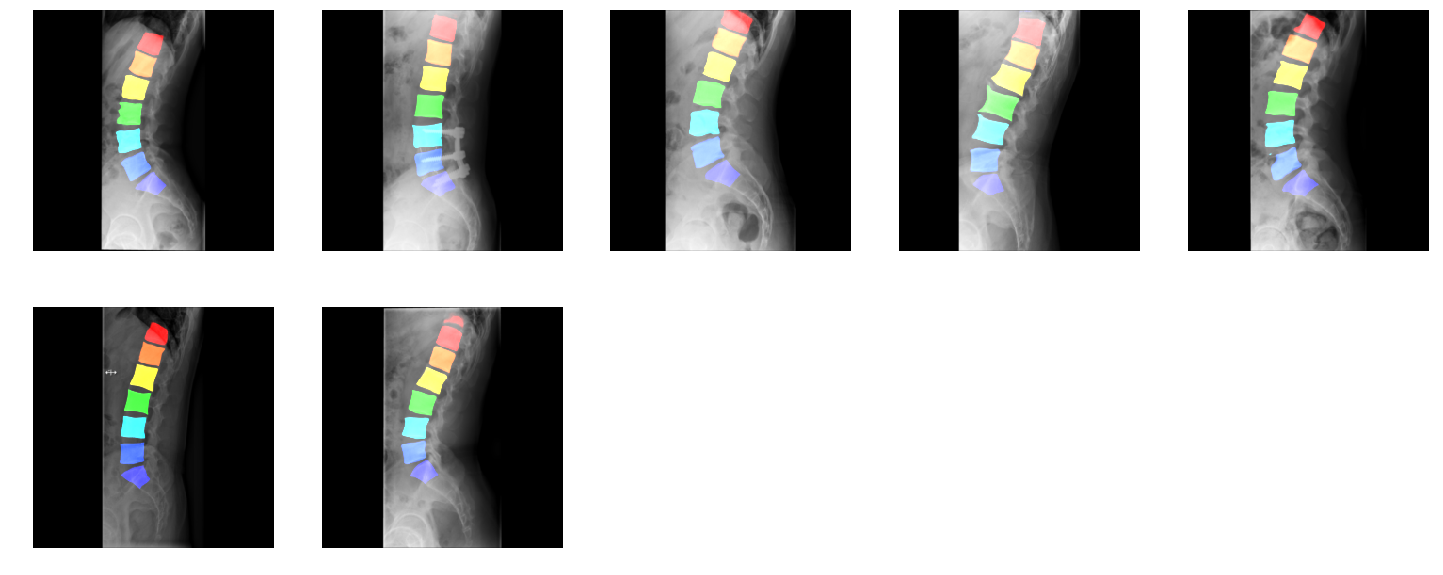

In [14]:
checkpointer = ModelCheckpoint(model_name2,
                               monitor='val_mean_iou',
                               mode='max',
                               verbose=1,
                               save_best_only=True)

results=model.fit_generator(train_generator,
                            validation_data=val_generator,
                            validation_steps=1,
                            steps_per_epoch=100,
                            epochs=500,
                            callbacks=[checkpointer])

model=load_model(model_name2,custom_objects={'mean_iou':mean_iou})
imshow2(overlay(images_val,level2(model.predict(images_val))))

# multi_gpu_model save는 중대한 문제가 있다
## workaround: https://github.com/keras-team/keras/issues/8446